In [1]:
# %%capture
# Only need to run the first time.
# Works with latest triton. Sorry, this takes a minute to install.
# !apt install libcairo2-dev pkg-config python3-dev
# !pip install jaxtyping
# !pip install git+https://github.com/Deep-Learning-Profiling-Tools/triton-viz@v1.1.1
# !pip install triton-3.1.0
# !pip install pycairo
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
# !ldconfig /usr/lib64-nvidia

import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import Float32, Int32

# @title Setup

import triton_viz
import inspect
from triton_viz.interpreter import record_builder

assert torch.cuda.is_available()

def test(puzzle, puzzle_spec, nelem={}, B={"B0": 32}, viz=False):
    B = dict(B)
    if "N1" in nelem and "B1" not in B:
        B["B1"] = 32
    if "N2" in nelem and "B2" not in B:
        B["B2"] = 32

    triton_viz.interpreter.record_builder.reset()
    torch.manual_seed(0)
    signature = inspect.signature(puzzle_spec)
    args = {}
    for n, p in signature.parameters.items():
        print(p)
        args[n + "_ptr"] = ([d.size for d in p.annotation.dims], p)
    args["z_ptr"] = ([d.size for d in signature.return_annotation.dims], None)

    tt_args = []
    for k, (v, t) in args.items():
        tt_args.append(torch.rand(*v, device='cuda') - 0.5)
        if t is not None and t.annotation.dtypes[0] == "int32":
            tt_args[-1] = torch.randint(-100000, 100000, v)
    grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)),
                         triton.cdiv(nelem.get("N2", 1), meta.get("B2", 1)))

    #for k, v in args.items():
    #    print(k, v)
    if viz:
        triton_viz.trace(puzzle)[grid](*tt_args, **B, **nelem)
    puzzle[grid](*tt_args, **B, **nelem)
    
    z = tt_args[-1]
    tt_args = tt_args[:-1]
    z_ = puzzle_spec(*tt_args)
    match = torch.allclose(z.cpu(), z_.cpu(), rtol=1e-3, atol=1e-3)
    # match = torch.allclose(z, z_, rtol=1e-3, atol=1e-3)
    print("Results match:",  match)
    failures = False
    if viz:
        failures = triton_viz.launch()
    if not match or failures:
        print("Invalid Access:", failures)
        print("Yours:", z)
        print("Spec:", z_)
        print(torch.isclose(z, z_))
        return
    print("Correct!")

# Puzzle 1: Constant Add <!--AsggNXj3NEmSGzbCXV2bap-->

Add a constant to a vector. Uses one program id axis. Block size `B0` is always the same as vector `x` with length `N0`.

$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$

![](imgs/puzzle_1.png)

```python
def add_spec(x: Float32[Tensor, "32"]) -> Float32[Tensor, "32"]:
    "This is the spec that you should implement. Uses typing to define sizes."
    return x + 10.

@triton.jit
def add_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):
    range = tl.arange(0, B0)
    x = tl.load(x_ptr + range)
    # Finish me!

test(add_kernel, add_spec, nelem={"N0": 32}, viz=True)
```

---

In [2]:
def add_spec(x: Float32[Tensor, "32"]) -> Float32[Tensor, "32"]:
    "This is the spec that you should implement. Uses typing to define sizes."
    return x + 10.

@triton.jit
def add_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):
    offsets = tl.arange(0, B0)
    x = tl.load(x_ptr + offsets)
    z = x + 10
    tl.store(z_ptr + offsets, z)

test(add_kernel, add_spec, nelem={"N0": 32}, viz=False)

x: jaxtyping.Float32[Tensor, '32']
Results match: True
Correct!


# Puzzle 2: Constant Add Block <!--JFib3RZKFFm3dYHcJ5tJUE-->

Add a constant to a vector. Uses one program block axis (no `for` loops yet). Block size `B0` is now smaller than the shape vector `x` which is `N0`.


$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$

![](imgs/puzzle_2.png)

```python
def add2_spec(x: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    return x + 10.

@triton.jit
def add_mask2_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):
    return

test(add_mask2_kernel, add2_spec, nelem={"N0": 200})
```

---

In [3]:
def add2_spec(x: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    return x + 10.

@triton.jit
def add_mask2_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):
    # blockIdx.x*blockDim.x + threadIdx.x
    offsets = tl.program_id(0)*B0 + tl.arange(0, B0)
    
    x = tl.load(x_ptr + offsets, offsets < N0)
    z = x + 10
    tl.store(z_ptr + offsets, z, offsets < N0)
    
test(add_mask2_kernel, add2_spec, nelem={"N0": 200})

x: jaxtyping.Float32[Tensor, '200']
Results match: True
Correct!


# Puzzle 3: Outer Vector Add <!--TzTDApXBx24cvFx2Bn9nfE-->

Add two vectors.

Uses one program block axis. Block size `B0` is always the same as vector `x` length `N0`.
Block size `B1` is always the same as vector `y` length `N1`.


$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots B_0,\ j = 1\ldots B_1$$

![](imgs/puzzle_3.png)


```python
def add_vec_spec(x: Float32[Tensor, "32"], y: Float32[Tensor, "32"]) -> Float32[Tensor, "32 32"]:
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    return

test(add_vec_kernel, add_vec_spec, nelem={"N0": 32, "N1": 32})
```

---

- x: (1, N0)
- y: (N1, 1)
- Output: (N1, N0)

In [4]:
def add_vec_spec(x: Float32[Tensor, "32"], y: Float32[Tensor, "32"]) -> Float32[Tensor, "32 32"]:
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    x = tl.load(x_ptr + tl.arange(0, B0))
    y = tl.load(y_ptr + tl.arange(0, B1))
    
    z = x[None, :] + y[:, None]
    
    tl.store(z_ptr + tl.arange(0, B0*B1), tl.reshape(z, (B0*B1)))

test(add_vec_kernel, add_vec_spec, nelem={"N0": 32, "N1": 32})

x: jaxtyping.Float32[Tensor, '32']
y: jaxtyping.Float32[Tensor, '32']
Results match: True
Correct!


# Puzzle 4: Outer Vector Add Block <!--M56mubwfEtQKkBpgBLM3pU-->

Add a row vector to a column vector.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$

![](imgs/puzzle_4.png)

```python
def add_vec_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
...

test(add_vec_block_kernel, add_vec_block_spec, nelem={"N0": 100, "N1": 90})
```

---

In [5]:
def add_vec_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    x_offsets = tl.program_id(0)*B0 + tl.arange(0, B0)
    y_offsets = tl.program_id(1)*B1 + tl.arange(0, B1)

    x = tl.load(x_ptr + x_offsets, mask=x_offsets < N0)
    y = tl.load(y_ptr + y_offsets, mask=y_offsets < N1)
    z = x[None, :] + y[:, None]

    z_offsets = x_offsets[None, :] + y_offsets[:, None]*N0
    z_mask = (x_offsets[None, :] < N0) & (y_offsets[:, None] < N1)
    tl.store(z_ptr + z_offsets, z, mask=z_mask)

test(add_vec_block_kernel, add_vec_block_spec, nelem={"N0": 100, "N1": 90})

x: jaxtyping.Float32[Tensor, '100']
y: jaxtyping.Float32[Tensor, '90']
Results match: True
Correct!


## Visualizations on Mask and Block Coords

In [6]:
import numpy as tl

In [7]:
N0 = 8
N1 = 6
B0 = 4
B1 = 3
pid_0 = 0
pid_1 = 0

In [8]:
# Mask at pid_0 = 0, pid_1 = 0
(tl.arange(0, B0)[None, :] + pid_0*B0) + (tl.arange(0, B1)[:, None] + pid_1*B1)

array([[0, 1, 2, 3],
       [1, 2, 3, 4],
       [2, 3, 4, 5]])

In [9]:
# block_coords at pid_0 = 0, pid_1 = 0
(tl.arange(0, B0)[None, :] + pid_0*B0) + (tl.arange(0, B1)[:, None]*N0 + pid_1*B1*N0)

array([[ 0,  1,  2,  3],
       [ 8,  9, 10, 11],
       [16, 17, 18, 19]])

In [10]:
N0 = 8
N1 = 6
B0 = 4
B1 = 3
pid_0 = 1
pid_1 = 1

### Mask

#### Row

In [11]:
tl.arange(0, B0)[None, :] + pid_0*B0

array([[4, 5, 6, 7]])

#### Column

In [12]:
tl.arange(0, B1)[:, None] + pid_1*B1

array([[3],
       [4],
       [5]])

#### Mask

In [13]:
(tl.arange(0, B0)[None, :] + pid_0*B0) + (tl.arange(0, B1)[:, None] + pid_1*B1)

array([[ 7,  8,  9, 10],
       [ 8,  9, 10, 11],
       [ 9, 10, 11, 12]])

### Block Coords

#### Row

In [14]:
(tl.arange(0, B0)[None, :] + pid_0*B0)

array([[4, 5, 6, 7]])

#### Column

In [15]:
(tl.arange(0, B1)[:, None])

array([[0],
       [1],
       [2]])

In [16]:
(tl.arange(0, B1)[:, None] + pid_1*B1)

array([[3],
       [4],
       [5]])

In [17]:
(tl.arange(0, B1)[:, None] + pid_1*B1)*N0

array([[24],
       [32],
       [40]])

In [18]:
(tl.arange(0, B0)[None, :] + pid_0*B0) + (tl.arange(0, B1)[:, None]*N0 + pid_1*B1*N0)

array([[28, 29, 30, 31],
       [36, 37, 38, 39],
       [44, 45, 46, 47]])

In [19]:
import triton.language as tl

# Puzzle 5: Fused Outer Multiplication <!--PwtpiDpJW8W8TKXVCjMy26-->

Multiply a row vector to a column vector and take a relu.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = \text{relu}(x_i \times y_j)\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$

![](imgs/puzzle_5.png)

```python
def mul_relu_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return torch.relu(x[None, :] * y[:, None])

@triton.jit
def mul_relu_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    ...
    
test(mul_relu_block_kernel, mul_relu_block_spec, nelem={"N0": 100, "N1": 90})
```

---

In [20]:
def mul_relu_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return torch.relu(x[None, :] * y[:, None])

@triton.jit
def mul_relu_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    x_offsets = tl.program_id(0)*B0 + tl.arange(0, B0)
    y_offsets = tl.program_id(1)*B1 + tl.arange(0, B1)

    x = tl.load(x_ptr + x_offsets, mask=x_offsets < N0, other=0.0)
    y = tl.load(y_ptr + y_offsets, mask=y_offsets < N1, other=0.0)
    z = tl.maximum(x[None, :] * y[:, None], 0) # tl.maximum(x[None, :] * y[:, None], tl.zeros((B1, B0), tl.float32))
    
    output_offsets = x_offsets[None, :] + y_offsets[:, None]*N0
    output_mask = (x_offsets[None, :] < N0) & (y_offsets[:, None] < N1)
    tl.store(z_ptr + output_offsets, z, mask=output_mask)
    
test(mul_relu_block_kernel, mul_relu_block_spec, nelem={"N0": 100, "N1": 90})

x: jaxtyping.Float32[Tensor, '100']
y: jaxtyping.Float32[Tensor, '90']
Results match: True
Correct!


# Puzzle 6: Fused Outer Multiplication - Backwards <!--J4yTike65Ye6RNECTp4iyo-->


Backwards of a function that multiplies a matrix with a row vector and take a relu.

Uses two program blocks. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`. Chain rule backward `dz`
is of shape `N1` by `N0`

$$f(x, y) = \text{relu}(x_{i, j} \times y_j)\text{ for } i = 1\ldots N_1,\ j = 1\ldots N_0$$

$$dx_{i, j} = f_x'(x, y)_{i, j} \times dz_{i,j}$$

![](imgs/puzzle_6.png)


```python
def mul_relu_block_back_spec(x: Float32[Tensor, "90 100"], y: Float32[Tensor, "90"],
                             dz: Float32[Tensor, "90 100"]) -> Float32[Tensor, "90 100"]:
    x = x.clone()
    y = y.clone()
    x = x.requires_grad_(True)
    y = y.requires_grad_(True)
    z = torch.relu(x * y[:, None])
    z.backward(dz)
    dx = x.grad
    return dx

@triton.jit
def mul_relu_block_back_kernel(x_ptr, y_ptr, dz_ptr, dx_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    ...

test(mul_relu_block_back_kernel, mul_relu_block_back_spec, nelem={"N0": 100, "N1": 90})
```

---

ReLU:
$$
\text{relu}(a) = 
\begin{cases} 
a & \text{if } a > 0 \\
0 & \text{if } a \leq 0
\end{cases}
$$

$$
\text{relu}'(a) = 
\begin{cases} 
1 & \text{if } a > 0 \\
0 & \text{if } a \leq 0
\end{cases}
$$

Problem statement:
$$f(x, y) = \text{relu}(x_i \times y_j)\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$

$$dx_{i, j} = f_x'(x, y)_{i, j} \times dz_{i,j}$$

Gradient:

$$
f_x'(x, y)_{ij} = 
\begin{cases} 
y_j & \text{if } x_i \cdot y_j > 0 \\
0 & \text{if } x_i \cdot y_j \leq 0
\end{cases}
$$

$$
dx_{ij} = \begin{cases} 
y_j \times dz_{ij} & \text{if } x_i \cdot y_j > 0 \\
0 & \text{if } x_i \cdot y_j \leq 0
\end{cases}
$$

In [21]:
def mul_relu_block_back_spec(x: Float32[Tensor, "90 100"], y: Float32[Tensor, "90"],
                             dz: Float32[Tensor, "90 100"]) -> Float32[Tensor, "90 100"]:
    x = x.clone()
    y = y.clone()
    x = x.requires_grad_(True)
    y = y.requires_grad_(True)
    z = torch.relu(x * y[:, None])
    z.backward(dz)
    dx = x.grad
    return dx

@triton.jit
def mul_relu_block_back_kernel(x_ptr, y_ptr, dz_ptr, dx_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    row_offsets = tl.program_id(0)*B0 + tl.arange(0, B0)
    col_offsets = tl.program_id(1)*B1 + tl.arange(0, B1)
    y = tl.load(y_ptr + col_offsets, mask=col_offsets<N1)

    block_coords = row_offsets[None, :] + col_offsets[:, None]*N0
    block_mask = (row_offsets[None, :] < N0) & (col_offsets[:, None] < N1)
    x = tl.load(x_ptr + block_coords, mask=block_mask)
    dz = tl.load(dz_ptr + block_coords, mask=block_mask)

    product = tl.maximum(x * y[:, None], 0) # (B1, B0)
    relu_positive_mask = tl.where(product > 0, 1, 0)
    dx = relu_positive_mask * y[:, None] * dz

    tl.store(dx_ptr + block_coords, dx, mask=block_mask)
    
test(mul_relu_block_back_kernel, mul_relu_block_back_spec, nelem={"N0": 100, "N1": 90})

x: jaxtyping.Float32[Tensor, '90 100']
y: jaxtyping.Float32[Tensor, '90']
dz: jaxtyping.Float32[Tensor, '90 100']
Results match: True
Correct!


Results match: True
Correct!


# Puzzle 7: Long Sum <!--QRQ6brZTz2LGubRxxsCzoP-->

Sum of a batch of numbers.

Uses one program blocks. Block size `B0` represents a range of batches of  `x` of length `N0`.
Each element is of length `T`. Process it `B1 < T` elements at a time.  

$$z_{i} = \sum^{T}_j x_{i,j} =  \text{ for } i = 1\ldots N_0$$

Hint: You will need a for loop for this problem. These work and look the same as in Python.

![](imgs/puzzle_7.png)

```python
def sum_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4"]:
    return x.sum(1)

@triton.jit
def sum_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    return

test(sum_kernel, sum_spec, B={"B0": 1, "B1": 32}, nelem={"N0": 4, "N1": 32, "T": 200})
```

---

- Is this row-wise or column-wise?
    - Summing along row, row-wise
- Which dim are we squashing? 
    - dim=-1, dim=1 (last dim)

In [22]:
def sum_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4"]:
    return x.sum(1)

@triton.jit
def sum_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    col_offsets = tl.program_id(0)*B0 + tl.arange(0, B0)

    sum_vec = tl.zeros((B0,), tl.float32)
    for j in range(0, T, B1):
        row_offsets = tl.arange(0, B1) + j

        block_coords = row_offsets[None, :] + col_offsets[:, None]*T
        block_mask = (row_offsets[None, :] < T) & (col_offsets[:, None] < N0)
        
        x = tl.load(x_ptr + block_coords, mask=block_mask)
        sum_vec = sum_vec + tl.sum(x, axis=1)

    tl.store(z_ptr + col_offsets, sum_vec, mask=col_offsets<N0)

test(sum_kernel, sum_spec, B={"B0": 1, "B1": 32}, nelem={"N0": 4, "N1": 32, "T": 200})

x: jaxtyping.Float32[Tensor, '4 200']
Results match: True
Correct!


# Puzzle 8: Long Softmax <!--7Tp448stbYTXdU2MQrd4N2-->

Softmax of a batch of logits.

Uses one program block axis. Block size `B0` represents the batch of `x` of length `N0`.
Block logit length `T`.   Process it `B1 < T` elements at a time.  

$$z_{i, j} = \text{softmax}(x_{i,1} \ldots x_{i, T}) \text{ for } i = 1\ldots N_0$$

Note softmax needs to be computed in numerically stable form as in Python. In addition in Triton they recommend not using `exp` but instead using `exp2`. You need the identity

$$\exp(x) = 2^{\log_2(e) x}$$

Advanced: there one way to do this with 3 loops. You can also do it with 2 loops if you are clever. Hint: you will find this identity useful:

$$\exp(x_i - m) =  \exp(x_i - m/2 - m/2) = \exp(x_i - m/ 2) /  \exp(m/2)$$

![](imgs/puzzle_8.png)

```python
def softmax_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4 200"]:
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    return x_exp / x_exp.sum(1, keepdim=True)

@triton.jit
def softmax_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    log2_e = 1.44269504
    return

test(softmax_kernel, softmax_spec, B={"B0": 1, "B1":32}, nelem={"N0": 4, "N1": 32, "T": 200})
```

---

In [23]:
def softmax_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4 200"]:
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    return x_exp / x_exp.sum(1, keepdim=True)

@triton.jit
def softmax_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    row_offsets = tl.program_id(0)*B0 + tl.arange(0, B0)

    exp_sum = tl.zeros((B0, 1), tl.float32)
    row_max = tl.full((B0, 1), -float("inf"), tl.float32)
    for j in range(0, T, B1):
        col_offsets = tl.arange(0, B1) + j
        block_coords = col_offsets[None, :] + row_offsets[:, None]*T
        block_mask = (col_offsets[None, :] < T) & (row_offsets[:, None] < N0)

        x = tl.load(x_ptr + block_coords, mask=block_mask, other=-float("inf")) # (B0, B1)
        new_row_max = tl.maximum(row_max, tl.max(x, axis=1))
        max_reset_factor = tl.exp(row_max - new_row_max)
        exp_sum = exp_sum*max_reset_factor + tl.sum(tl.exp(x - new_row_max), axis=1)

        row_max = new_row_max

    for j in range(0, T, B1):
        col_offsets = tl.arange(0, B1) + j
        block_coords = col_offsets[None, :] + row_offsets[:, None]*T
        block_mask = (col_offsets[None, :] < T) & (row_offsets[:, None] < N0)

        x = tl.load(x_ptr + block_coords, mask=block_mask, other=-float("inf"))

        tl.store(
            z_ptr + block_coords,
            tl.exp(x - row_max) / exp_sum,
            mask=block_mask
        )
        

test(softmax_kernel, softmax_spec, B={"B0": 1, "B1":32}, nelem={"N0": 4, "N1": 32, "T": 200})

x: jaxtyping.Float32[Tensor, '4 200']
Results match: True
Correct!


# Puzzle 9: Simple FlashAttention <!--4ZfqM6qDzJqrxWPCdRGMaS-->

A scalar version of FlashAttention.

- Each query, key vector only has 1 dim (hence scalar flash attention)
- Uses zero programs. Block size `B0` represent the batches of `q` to process out of `N0`.
- Sequence length is `T`. Process it `B1 < T` elements (`k`, `v`) at a time for some `B1`.
- `N0` = `T`since `q` and `k` are the same size
- Since in attention: qk, we're doing every pair-wise combination of each element of q and k:
    - \[T, N_MODEL\] * \[N_MODEL, T\]
    - N_MODEL = 1

$$z_{i} = \sum_{j} \text{softmax}(q_1 k_1, \ldots, q_T k_T)_j v_{j} \text{ for } i = 1\ldots N_0$$

This can be done in 1 loop using a similar trick from the last puzzle.

Hint: Use `tl.where` to mask `q dot k` to -inf to avoid overflow (NaN).

![](imgs/puzzle_9.png)

```python
def flashatt_spec(q: Float32[Tensor, "200"], k: Float32[Tensor, "200"], v: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    x = q[:, None] * k[None, :]
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    soft =  x_exp  / x_exp.sum(1, keepdim=True)
    return (v[None, :] * soft).sum(1)

@triton.jit
def flashatt_kernel(q_ptr, k_ptr, v_ptr, z_ptr, N0, T, B0: tl.constexpr, B1: tl.constexpr):
    return

test(flashatt_kernel, flashatt_spec, B={"B0": 64, "B1": 32}, nelem={"N0": 200, "T": 200})
```

---

In [24]:
def flashatt_spec(q: Float32[Tensor, "200"], k: Float32[Tensor, "200"], v: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    x = q[:, None] * k[None, :]
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    soft =  x_exp  / x_exp.sum(1, keepdim=True)
    return (v[None, :] * soft).sum(1)

@triton.jit
def flashatt_kernel(q_ptr, k_ptr, v_ptr, z_ptr, N0, T, B0: tl.constexpr, B1: tl.constexpr):
    q_offset = tl.program_id(0)*B0 + tl.arange(0, B0)
    q = tl.load(q_ptr + q_offset, mask = q_offset < N0)

    exp_sum = tl.zeros((B0, 1), tl.float32)
    row_max = tl.full((B0, 1), -float("inf"), tl.float32)
    o_partial = tl.zeros((B0, 1), tl.float32)
    for j in range(0, T, B1):
        k_offset = tl.arange(0, B1) + j
        k = tl.load(k_ptr + k_offset, mask = k_offset < T)

        block_mask = (q_offset[:, None] < N0) & (k_offset[None, :] < T)
        qk = q[:, None] * k[None, :] + tl.where(block_mask, 0, -float("inf")) # (B0, B1)

        new_row_max = tl.maximum(row_max, tl.max(qk, axis=1)[:, None])
        max_reset_factor = tl.exp(row_max - new_row_max)

        exp_sum = exp_sum*max_reset_factor + tl.sum(tl.exp(qk - new_row_max), axis=1)[:, None]

        v = tl.load(v_ptr + k_offset, mask = k_offset < T)
        o_partial = o_partial*max_reset_factor + tl.sum(tl.exp(qk - new_row_max)*v[None, :], axis=1)[:, None]

        row_max = new_row_max
    
    tl.store(
        z_ptr + q_offset,
        (o_partial / exp_sum).reshape((B0,)),
        mask = q_offset < N0
    )

test(flashatt_kernel, flashatt_spec, B={"B0": 64, "B1": 32}, nelem={"N0": 200, "T": 200})

q: jaxtyping.Float32[Tensor, '200']
k: jaxtyping.Float32[Tensor, '200']
v: jaxtyping.Float32[Tensor, '200']
Results match: True
Correct!


# Puzzle 10: Two Dimensional Convolution <!--GuKDzvV9CkZUv3PwvFdeUE-->

A batched 2D convolution.

Uses one program id axis. Block size `B0` represent the batches to process out of `N0`.
Image `x` is size is `H` by `W` with only 1 channel, and kernel `k` is size `KH` by `KW`.

$$z_{i, j, k} = \sum_{oj, ok} k_{oj,ok} \times x_{i,j + oj, k + ok} \text{ for } i = 1\ldots N_0$$

![](imgs/puzzle_10.png)

```python
def conv2d_spec(x: Float32[Tensor, "4 8 8"], k: Float32[Tensor, "4 4"]) -> Float32[Tensor, "4 8 8"]:
    z = torch.zeros(4, 8, 8)
    x = torch.nn.functional.pad(x, (0, 4, 0, 4, 0, 0), value=0.0)
    print(x.shape, k.shape)
    for i in range(8):
        for j in range(8):
            z[:, i, j] = (k[None, :, :] * x[:, i: i+4, j: j + 4]).sum(1).sum(1)
    return z


@triton.jit
def conv2d_kernel(x_ptr, k_ptr, z_ptr, N0, H, W, KH: tl.constexpr, KW: tl.constexpr, B0: tl.constexpr):
    pid_0 = tl.program_id(0)
    return

test(conv2d_kernel, conv2d_spec, B={"B0": 1}, nelem={"N0": 4, "H": 8, "W": 8, "KH": 4, "KW": 4})
```

---

In [ ]:
def conv2d_spec(x: Float32[Tensor, "4 8 8"], k: Float32[Tensor, "4 4"]) -> Float32[Tensor, "4 8 8"]:
    z = torch.zeros(4, 8, 8)
    x = torch.nn.functional.pad(x, (0, 4, 0, 4, 0, 0), value=0.0)
    print(x.shape, k.shape)
    for i in range(8):
        for j in range(8):
            z[:, i, j] = (k[None, :, :] * x[:, i: i+4, j: j + 4]).sum(1).sum(1)
    return z

@triton.jit
def conv2d_kernel(x_ptr, k_ptr, z_ptr, N0, H, W, KH: tl.constexpr, KW: tl.constexpr, B0: tl.constexpr):
    pid_0 = tl.program_id(0)
    return

test(conv2d_kernel, conv2d_spec, B={"B0": 1}, nelem={"N0": 4, "H": 8, "W": 8, "KH": 4, "KW": 4})

# Puzzle 11: Matrix Multiplication <!--iAML6Vvvkqv9x9WeeDaZDK-->

A blocked matrix multiplication.

Uses three program id axes. Block size `B2` represent the batches to process out of `N2`.
Block size `B0` represent the rows of `x` to process out of `N0`. Block size `B1` represent the cols of `y` to process out of `N1`. The middle shape is `MID`.

$$z_{i, j, k} = \sum_{l} x_{i,j, l} \times y_{i, l, k} \text{ for } i = 1\ldots N_2, j = 1\ldots N_0, k = 1\ldots N_1$$

You are allowed to use `tl.dot` which computes a smaller mat mul.

Hint: the main trick is that you can split a matmul into smaller parts.

$$z_{i, j, k} = \sum_{l=1}^{L/2} x_{i,j, l} \times y_{i, l, k} +  \sum_{l=L/2}^{L} x_{i,j, l} \times y_{i, l, k} $$


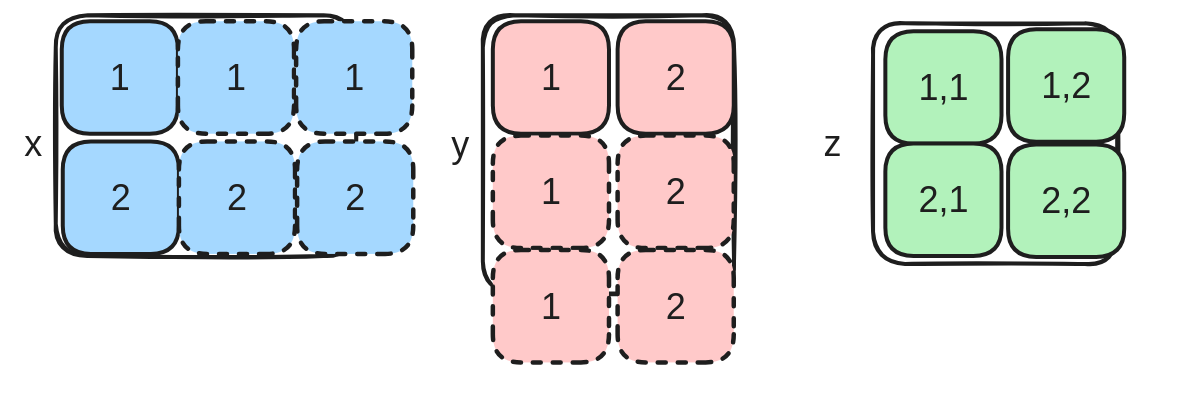

In [ ]:
def dot_spec(x: Float32[Tensor, "4 32 32"], y: Float32[Tensor, "4 32 32"]) -> Float32[Tensor, "4 32 32"]:
    return x @ y

@triton.jit
def dot_kernel(x_ptr, y_ptr, z_ptr, N0, N1, N2, MID, B0: tl.constexpr, B1: tl.constexpr, B2: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    pid_2 = tl.program_id(2)

test(dot_kernel, dot_spec, B={"B0": 16, "B1": 16, "B2": 1, "B_MID": 16}, nelem={"N0": 32, "N1": 32, "N2": 4, "MID": 32})


# Puzzle 12: Quantized Matrix Mult <!--VE6wuX9nQKgDeF67zbiV6C-->

When doing matrix multiplication with quantized neural networks a common strategy is to store the weight matrix in lower precision, with a shift and scale term.

For this problem our `weight` will be stored in 4 bits. We can store `FPINT` of these in a 32 bit integer. In addition for every `group` weights in order we will store 1 `scale` float value and 1 `shift` 4 bit value. We store these for the column of weight. The `activation`s are stored separately in standard floats.

Mathematically it looks like.

$$z_{j, k} = \sum_{l} sc_{j, \frac{l}{g}} (w_{j, l} - sh_{j, \frac{l}{g}}) \times y_{l, k} \text{ for } i = 1\ldots N_2, j = 1\ldots N_0, k = 1\ldots N_1$$

However, it is a bit more complex since we need to also extract the 4-bit values into floats to begin.




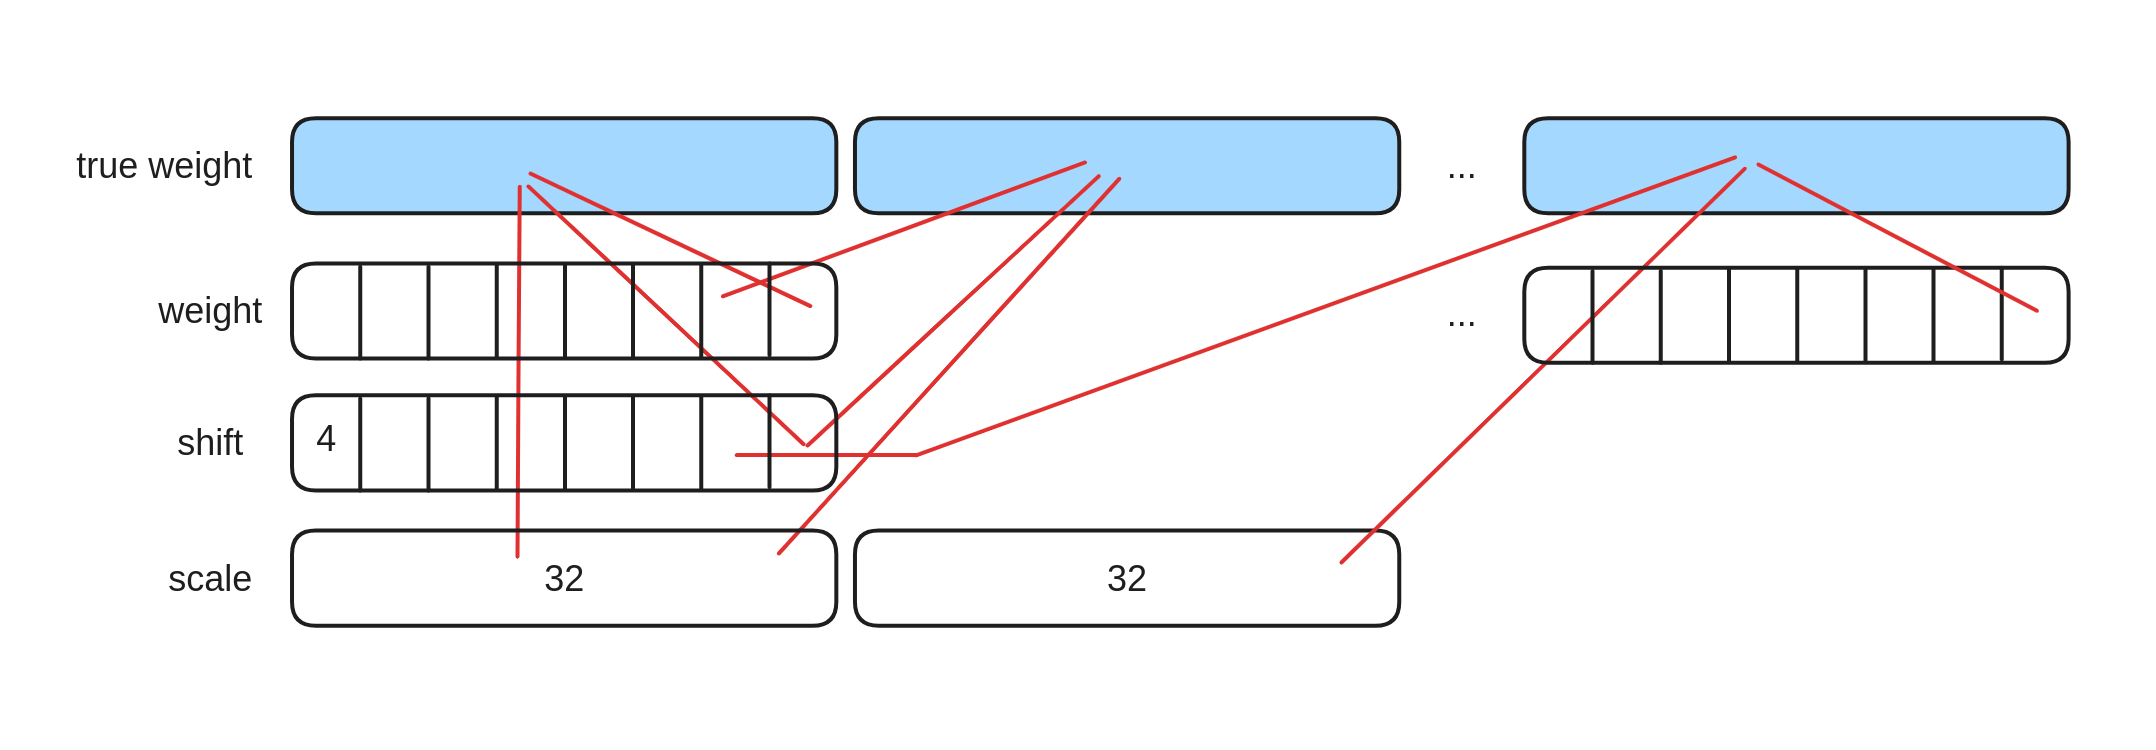

In [ ]:

FPINT = 32 // 4
GROUP = 8

def quant_dot_spec(scale : Float32[Tensor, "32 8"],
                   offset : Int32[Tensor, "32"],
                   weight: Int32[Tensor, "32 8"],
                   activation: Float32[Tensor, "64 32"]) -> Float32[Tensor, "32 32"]:
    offset = offset.view(32, 1)
    def extract(x):
        over = torch.arange(8) * 4
        mask = 2**4 - 1
        return (x[..., None] >> over) & mask
    scale = scale[..., None].expand(-1, 8, GROUP).contiguous().view(-1, 64)
    offset = extract(offset)[..., None].expand(-1, 1, 8, GROUP).contiguous().view(-1, 64)
    return ( scale * (extract(weight).view(-1, 64) - offset))  @ activation

@triton.jit
def quant_dot_kernel(scale_ptr, offset_ptr, weight_ptr, activation_ptr,
                     z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

test(quant_dot_kernel, quant_dot_spec, B={"B0": 16, "B1": 16, "B_MID": 64},
                                       nelem={"N0": 32, "N1": 32, "MID": 64})
